In [1]:
import pandas as pd
import json
import datetime, time
from sklearn.model_selection import train_test_split
import itertools
import os
import zipfile
import random
import numpy as np

import requests
import matplotlib.pyplot as plt

import scipy.sparse as sp
from sklearn.metrics import roc_auc_score


from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Layer
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

# Read data

In [2]:
df_movies = pd.read_csv("data/movies_cast_company.csv", encoding='utf8')
df_movies["cast"] = df_movies["cast"].apply(lambda x: json.loads(x))
df_movies["company"] = df_movies["company"].apply(lambda x: json.loads(x))

# TODO: just temporary, later remove
additional_rows = []#["title"]
df_movies = df_movies.drop(additional_rows+["url"]+list(df_movies.columns[-4:]), axis=1)

print(df_movies.shape)
df_movies.head()

(1315, 22)


,movie_id_ml,title,release,unknown,action,adventure,animation,childrens,comedy,crime,...,fantasy,noir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,toy story,1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,goldeneye,1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,four rooms,1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,get shorty,1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,copycat,1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [3]:
def string2ts(string, fmt="%Y-%m-%d %H:%M:%S"):
    dt = datetime.datetime.strptime(string, fmt)
    t_tuple = dt.timetuple()
    return int(time.mktime(t_tuple))

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")

# TODO: just temporary, later remove
df_ratings.rating_timestamp = df_ratings.rating_timestamp.apply(lambda x: string2ts(x))

print(df_ratings.shape)
df_ratings.head()

(100000, 4)


,user_id,movie_id_ml,rating,rating_timestamp
0,196,242,3,881247349
1,186,302,3,891710542
2,22,377,1,878883516
3,244,51,2,880603323
4,166,346,1,886393996


In [5]:
df_users = pd.read_csv("data/users.csv")

# TODO: just temporary, later remove
additional_rows = ["user_zipcode"]
df_users = df_users.drop(additional_rows, axis=1)

num2occupation = dict(enumerate(df_users.user_occupation.unique()))
occupation2num = {y:x for x,y in num2occupation.items()}
num2gender = dict(enumerate(df_users.user_gender.unique()))
gender2num = {y:x for x,y in num2gender.items()}
df_users.user_occupation = df_users.user_occupation.apply(lambda x: occupation2num[x])
df_users.user_gender = df_users.user_gender.apply(lambda x: gender2num[x])


print(df_users.shape)
df_users.head()

(943, 4)


,user_id,user_age,user_gender,user_occupation
0,1,24,0,0
1,2,53,1,1
2,3,23,0,2
3,4,24,0,0
4,5,33,1,1


##### All

In [6]:
df = pd.merge(df_movies, df_ratings, on="movie_id_ml")
df = pd.merge(df, df_users, on="user_id")

print(df.shape)
df.head()

(90851, 28)


,movie_id_ml,title,release,unknown,action,adventure,animation,childrens,comedy,crime,...,scifi,thriller,war,western,user_id,rating,rating_timestamp,user_age,user_gender,user_occupation
0,1,toy story,1995,0,0,0,1,1,1,0,...,0,0,0,0,308,4,887732932,60,0,18
1,4,get shorty,1995,0,1,0,0,0,1,0,...,0,0,0,0,308,5,887734290,60,0,18
2,5,copycat,1995,0,0,0,0,0,0,1,...,0,1,0,0,308,4,887736008,60,0,18
3,7,twelve monkeys,1995,0,0,0,0,0,0,0,...,1,0,0,0,308,4,887735247,60,0,18
4,8,babe,1995,0,0,0,0,1,1,0,...,0,0,0,0,308,5,887733096,60,0,18


In [7]:
# movies
id2movie = dict(enumerate(df.movie_id_ml.unique()))
movie2id = {y:x for x,y in id2movie.items()}

# users
id2user = dict(enumerate(df.user_id.unique()))
user2id = {y:x for x,y in id2user.items()}

# Friends
def slice_by_lengths(lengths, the_list):
    for length in lengths:
        new = []
        for i in range(length):
            new.append(the_list.pop(0))
        yield new
        
user_ids = list(df_users.user_id.unique())
total_users = len(user_ids)
lengths_sum = 0
lengths = []

for i in range(total_users):
    length = random.randint(2, 8)
    
    if lengths_sum+length > total_users:
        length = total_users - lengths_sum
        lengths_sum += length
        lengths.append(length)
        break
    elif lengths_sum+length == total_users:
        lengths_sum += length
        lengths.append(length)
        break
    else:
        lengths_sum += length
        lengths.append(length)
        
friend_ids = [i for i in enumerate(slice_by_lengths(lengths, user_ids))]

user2friendsid = {}
for fid_and_uids in friend_ids:
    for uid in fid_and_uids[1]:
        user2friendsid[uid] = fid_and_uids[0]


In [8]:
df["iid"] = df.apply(lambda x: movie2id[x.movie_id_ml], axis=1)
df["uid"] = df.apply(lambda x: user2id[x.user_id], axis=1)
df["fid"] = df.apply(lambda x: user2friendsid[x.user_id], axis=1)

In [9]:
fid2avgage = dict(df.groupby("fid")["user_age"].agg(np.mean))
fid2medianrating = dict(df.groupby(["fid","iid"])["rating"].agg(np.median))

In [10]:
df["fid_user_avg_age"] = df.apply(lambda x: fid2avgage[x.fid], axis=1)
df["rating"] = df.apply(lambda x: fid2medianrating[(x.fid, x.iid)], axis=1)

In [11]:
df = df.drop(["uid", "user_gender", "user_occupation", "user_age", "user_id", "rating_timestamp"], axis=1)

In [12]:
df

,movie_id_ml,title,release,unknown,action,adventure,animation,childrens,comedy,crime,...,mystery,romance,scifi,thriller,war,western,rating,iid,fid,fid_user_avg_age
0,1,toy story,1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,4.0,0,63,47.392086
1,4,get shorty,1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,4.0,1,63,47.392086
2,5,copycat,1995,0,0,0,0,0,0,1,...,0,0,0,1,0,0,3.5,2,63,47.392086
3,7,twelve monkeys,1995,0,0,0,0,0,0,0,...,0,0,1,0,0,0,4.0,3,63,47.392086
4,8,babe,1995,0,0,0,0,1,1,0,...,0,0,0,0,0,0,5.0,4,63,47.392086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90846,748,the saint,1997,0,1,0,0,0,0,0,...,0,1,0,1,0,0,4.0,348,140,27.274428
90847,751,tomorrow never dies,1997,0,1,0,0,0,0,0,...,0,1,0,1,0,0,3.0,447,140,27.274428
90848,879,the peacemaker,1997,0,1,0,0,0,0,0,...,0,0,0,1,1,0,3.5,659,140,27.274428
90849,894,home alone 3,1997,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1.0,875,140,27.274428


In [13]:
df = df.drop_duplicates()

In [18]:
friends_age = df[df.fid == friend_ids[-1][0]]["fid_user_avg_age"].iloc[0]
print(f"Average age of this new friends group: {friends_age}")
# TODO; remove this line when real user
new_friends_data = np.array(df[df.fid == friend_ids[-1][0]][["fid", "iid", "rating"]].values.tolist())

Average age of this new friends group: 30.12549019607843


##### Prepare for new user

In [15]:
# TODO; remove this line when real user
new_friends_id = friend_ids[-1][0] 
print(new_friends_id)
df = df[df.fid != new_friends_id]

191


In [16]:
# shape [n_users, n_user_features]
df_friends = df[["fid", "fid_user_avg_age"]].drop_duplicates()
print(f"Number of friends features: {df_friends.shape[0]}")

df_movies = df[["iid"]+list(df.columns[3:22])].drop_duplicates()
print(f"Number of movies features: {df_movies.shape[0]}")

Number of friends features: 191
Number of movies features: 1280


---

# Simulate our user input

First, `user_movie_ratings_training` is used to simulate initial user input that we will ask him to rate some random movies. Later, we will try to recommend movies to him, but we know what is his preference thanks to `user_movie_ratings_test`. Both lists are extracted from the existed dataset.

In [17]:
columns = ["fid", "iid", "rating", "fid_user_avg_age"]

# friends info
friends_age = friends_age
friends_id = new_friends_id

# ratings
train_idx, test_idx = train_test_split(range(new_friends_data.shape[0]), test_size=0.2, random_state=42)

friends_movie_ratings_training = new_friends_data[train_idx]
friends_movie_ratings_test = new_friends_data[test_idx]

In [18]:
df_friends = df_friends.append({"fid": new_friends_id, "fid_user_avg_age":friends_age}, ignore_index=True)
print(f"New number of friends features: {df_friends.shape[0]}")
print(f"New number of movies features: {df_movies.shape[0]}")

New number of friends features: 191
New number of movies features: 1280


In [19]:
# create new user dataframe with training data

data_new_friends_training = []
for x in friends_movie_ratings_training:
    data_new_friends_training.append(list(x)+[friends_age])

data_new_friends_test = []
for x in friends_movie_ratings_test:
    data_new_friends_test.append(list(x)+[friends_age])

# user initial input that will be given to him to rate it before recommendation
df_new_friends_train = pd.DataFrame(data_new_friends_training, columns=columns)
# the input that will be checked if recommendation works fine
df_new_friends_test = pd.DataFrame(data_new_friends_test, columns=columns)



# training and test data
train_idx, test_idx = train_test_split(range(df.shape[0]), test_size=0.2, random_state=42)

df_train = df.iloc[train_idx]
df_train = pd.concat([df_train, df_new_friends_train], sort=False)

df_test = df.iloc[test_idx]
df_test = pd.concat([df_test, df_new_friends_test], sort=False)

In [20]:
df_train = df_train[["fid", "iid", "rating"]].astype(np.int64)
df_test = df_test[["fid", "iid", "rating"]].astype(np.int64)
df_new_friends_train = df_new_friends_train[["fid", "iid", "rating"]].astype(np.int64)
df_new_friends_test = df_new_friends_test[["fid", "iid", "rating"]].astype(np.int64)

---

# Data Pre-Processing

In [21]:
fids = set(df_train.fid.unique()).union(set(df_test.fid.unique()))
iids = set(df_train.iid.unique()).union(set(df_test.iid.unique()))

rows = max(fids) + 1 
cols = max(iids) + 1

print("Friends number: ", len(fids), rows)
print("Movies number: ", len(iids), cols)

Friends number:  191 191
Movies number:  1280 1280


In [22]:
def _build_interaction_matrix(rows, cols, data):

    mat = sp.lil_matrix((rows, cols), dtype=np.int32)

    for uid, iid, rating in data:
        # Let's assume only really good things are positives
        if rating >= 4.0:
            mat[uid, iid] = 1.0

    return mat.tocoo()

def get_triplets(mat):
    return mat.row, mat.col, np.random.randint(mat.shape[1], size=len(mat.row))

def create_sparse_matrix(df):
    """
    Return (train_interactions, test_interactions).
    """
    return _build_interaction_matrix(rows, cols, df.values.tolist())

---

Using ROC curve from [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) and [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

In [23]:
def predict(model, uid, pids):
    user_vector = model.get_layer('user_embedding').get_weights()[0][uid]
    item_matrix = model.get_layer('item_embedding').get_weights()[0][pids]

    scores = (np.dot(user_vector,
                     item_matrix.T))

    return scores


def full_auc(model, ground_truth):
    """
    Measure AUC for model and ground truth on all items.

    Returns
    -------
    - float AUC
    """
    ground_truth = ground_truth.tocsr()

    no_users, no_items = ground_truth.shape

    pid_array = np.arange(no_items, dtype=np.int32)

    scores = []

    for user_id, row in enumerate(ground_truth):

        predictions = predict(model, user_id, pid_array)

        true_pids = row.indices[row.data == 1]

        grnd = np.zeros(no_items, dtype=np.int32)
        grnd[true_pids] = 1

        if len(true_pids):
            scores.append(roc_auc_score(grnd, predictions))

    return np.mean(scores)

---

# Model Implementation

Here, we add new custom layer called `TripletLossLayer`.

In [24]:
class TripletLossLayer(Layer):
    def call(self, inputs):
        positive_item_latent, negative_item_latent, user_latent = inputs

        # Bayesian Personalised Ranking (BPR) loss
        loss = 1.0 - K.sigmoid(
            K.sum(user_latent * positive_item_latent, axis=-1, keepdims=True) -
            K.sum(user_latent * negative_item_latent, axis=-1, keepdims=True))

        return loss

In [25]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

def build_model(num_users, num_items, latent_dim):

    positive_item_input = Input((1, ), name='positive_item_input')
    negative_item_input = Input((1, ), name='negative_item_input')

    # Shared embedding layer for positive and negative items
    item_embedding_layer = Embedding(num_items, latent_dim, name='item_embedding', input_length=1)
    user_input = Input((1, ), name='user_input')

    positive_item_embedding = Flatten()(item_embedding_layer(positive_item_input))
    negative_item_embedding = Flatten()(item_embedding_layer(negative_item_input))
    user_embedding = Flatten()(Embedding(num_users, latent_dim, name='user_embedding', input_length=1)(user_input))
    
    loss = TripletLossLayer()((positive_item_embedding, negative_item_embedding, user_embedding))
    
    model = Model([positive_item_input, negative_item_input, user_input], loss)
    
    model.compile(loss=identity_loss, optimizer=Adam())
    
    return model

In [26]:
# train.todense()

---

# Training

In [27]:
latent_dim = 100
num_epochs = 15

# Read data
train = create_sparse_matrix(df_train)
test = create_sparse_matrix(df_test)
num_users, num_items = train.shape

# Prepare the test triplets
test_uid, test_pid, test_nid = get_triplets(test)

model = build_model(num_users, num_items, latent_dim)

# Print the model structure
print(model.summary())

plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

# Sanity check, should be around 0.5
print(f'AUC before training {full_auc(model, test)}')



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
positive_item_input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
negative_item_input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 100)       128000      positive_item_input[0][0]        
                                                                 negative_item_input[0][0]    

In [28]:
accuracies_test = []
accuracies_train = []
losses = []

for epoch in range(num_epochs):

    print(f'Epoch {epoch}')

    # Sample triplets from the training data
    uid, pid, nid = get_triplets(train)

    X = {
        'user_input': uid,
        'positive_item_input': pid,
        'negative_item_input': nid
    }

    history = model.fit(X,
                      np.ones(len(uid)),
                      batch_size=64,
                      epochs=1,
                      verbose=0,
                      shuffle=True)
    loss = history.history["loss"]
    losses.append(loss)
    
    acc = full_auc(model, test)
    accuracies_test.append(acc)
    print(f'Test AUC {acc}')
    acc = full_auc(model, train)
    accuracies_train.append(acc)
    print(f'Train AUC {acc}\n')

Epoch 0
Test AUC 0.7928443824825799
Train AUC 0.8775900453523575

Epoch 1
Test AUC 0.8195760281040898
Train AUC 0.8536829473905423

Epoch 2
Test AUC 0.8212738889342602
Train AUC 0.8544862793421532

Epoch 3
Test AUC 0.8218531023008538
Train AUC 0.8554604358507136

Epoch 4
Test AUC 0.8217274022337012
Train AUC 0.856755811440639

Epoch 5
Test AUC 0.822938950672474
Train AUC 0.8575953957155389

Epoch 6
Test AUC 0.8231471081913783
Train AUC 0.8584778045180823

Epoch 7
Test AUC 0.8235495705178306
Train AUC 0.8599576261261469

Epoch 8
Test AUC 0.8230173404200156
Train AUC 0.8615733955288202

Epoch 9
Test AUC 0.82340651611271
Train AUC 0.8632527131944085

Epoch 10
Test AUC 0.8241682739275171
Train AUC 0.8653959653512798

Epoch 11
Test AUC 0.8243559577525438
Train AUC 0.8678940070103269

Epoch 12
Test AUC 0.8250446724788699
Train AUC 0.870974349777606

Epoch 13
Test AUC 0.8252898119643763
Train AUC 0.8740304466793817

Epoch 14
Test AUC 0.8258039296141678
Train AUC 0.8772777243996953



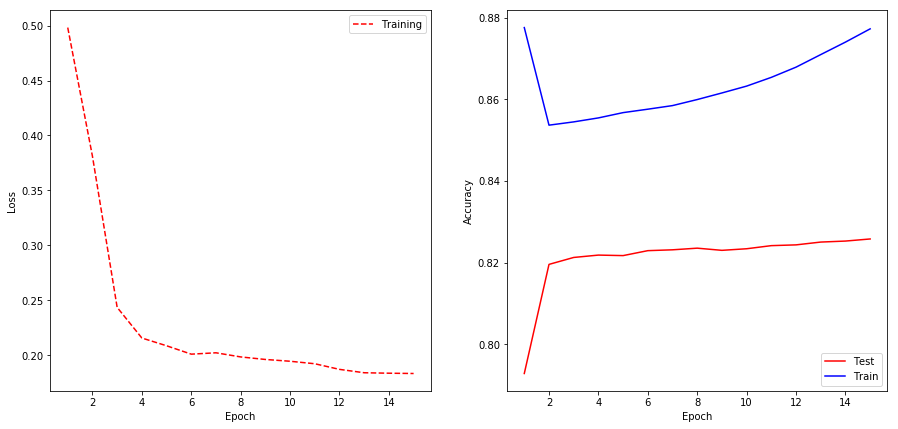

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, num_epochs + 1)

# Visualize loss history
ax1.plot(epoch_count, losses, 'r--', label='Training')
#ax1.plot(epoch_count, val_loss, 'b-', label='Validation')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, accuracies_test, 'r-', label='Test')
ax2.plot(epoch_count, accuracies_train, 'b-', label='Train')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.show();

---

# Observe the recommendation results for our friends

In [30]:
def predict_movies(model, friends_id):
    movie_ids = list(df.iid.unique())
    prediction = predict(model, friends_id, movie_ids)
    rated_high = [1 if np.round(i)>0.5 else 0 for i in prediction]
    good_movie_ids = np.where(np.array(rated_high) == 1)[0]  
    return list(good_movie_ids)

In [31]:
predicted_good_movies = predict_movies(model, friends_id)

In [32]:
friends_ratings = list(friends_movie_ratings_training) + list(friends_movie_ratings_test)
friends_ratings_positive = []
friends_ratings_negative = []
for ur in friends_ratings:
    if ur[2] >= 4:
        friends_ratings_positive.append(ur[1])
    else:
        friends_ratings_negative.append(ur[1])

In [33]:
for m in friends_ratings_positive:
    print(m if m in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER")

304.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
114.0
952.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
262.0
79.0
39.0
264.0
332.0
103.0
183.0
120.0
12.0
104.0
244.0
314.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
519.0
19.0
68.0
43.0
782.0
818.0
97.0
259.0
147.0
83.0
490.0
41.0
302.0
6.0
89.0
283.0
229.0
344.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
360.0
546.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
31.0
52.0
18.0
604.0
90.0
275.0
10.0
239.0
627.0
27.0
824.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
44.0
373.0
207.0
588.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
403.0
891.0
109.0
87.0
82.0
205.0
54.0
143.0
92.0
187.0
86.0
814.0
101.0
923.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
211.0
601.0
983.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
432.0
161.0
152.0
196.0
659.0
159.0
17.0
20.0
920.0
24.0
138.0
190.0
870.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
921.0
401.0
102.0
368.0
405

In [34]:
for m in friends_ratings_negative:
    print(m if m not in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER")

518.0
151.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
400.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
28.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
168.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
548.0
448.0
226.0
49.0
149.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
309.0
137.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
508.0
1124.0
887.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
918.0
506.0
516.0
353.0
107.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
554.0
356.0
802.0
378.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
42.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
926.0
51.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
433.0
240.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
379.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
108.0
407.0
295.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
440.0
383.0
515.0
81.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
171.0 PREDICTED W

In [35]:
friends_sparse_matrix = create_sparse_matrix(df_new_friends_test)
acc = full_auc(model, friends_sparse_matrix)
print(f"Accuracy for new user: {acc*100:.2f}%")

Accuracy for new user: 80.37%


Accuracy **93.1%** for this user is not bad, could be better! On the test set, accuracy on average is **90.9%**.

In [36]:
def predict_top_k_movies(model, friends_id, k):
    n_users, n_movies = train.shape
    prediction = predict(model, friends_id, np.arange(n_movies))
    movie_ids = df.iid.unique()
    return movie_ids[np.argsort(-prediction)][:k]

In [37]:
known_positives = df_train[(df_train.iid.isin(train.tocsr()[friends_id].indices))&(df_train.fid==friends_id)]["iid"]

k = 10
top_movies = predict_top_k_movies(model, friends_id, k)

print(f"Friends {friends_id}")
print("     Known positives:")
for x in known_positives[:k]:
    print(f"        {df[df.iid==x]['iid'].iloc[0]} | {df[df.iid==x]['title'].iloc[0]}" )
    
print("     Recommended:")
for x in top_movies:
    print(f"        {df[df.iid==x]['iid'].iloc[0]} | {df[df.iid==x]['title'].iloc[0]}" )

Friends 190
     Known positives:
        304 | charade
        114 | sneakers
        952 | the ghost and mrs. muir
        262 | arsenic and old lace
        79 | goodfellas
        39 | true romance
        264 | high noon
        332 | the truth about cats & dogs
        103 | cape fear
        183 | north by northwest
     Recommended:
        143 | one flew over the cuckoo's nest
        6 | the usual suspects
        52 | the godfather
        17 | star wars
        31 | the fugitive
        73 | raiders of the lost ark
        360 | the princess bride
        43 | the silence of the lambs
        80 | alien
        486 | contact


---

# LightFM

Much faster implementation that is similar doing of the code implemented above.

In [67]:
use_features = False

In [68]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

In [69]:
def my2csr(df):
    return sp.csr_matrix(df.values)

In [70]:
train = create_sparse_matrix(df_train)#, mat_type="ratings")
test = create_sparse_matrix(df_test)#, mat_type="ratings")

# shape [n_users, n_user_features]
friends_features = my2csr(df_friends)
item_features = my2csr(df_movies)

In [71]:
loss_type = "warp"  # "bpr"

model = LightFM(learning_rate=0.005, loss=loss_type, max_sampled=100)

if use_features:
    model.fit_partial(train, epochs=20, user_features=friends_features, item_features=item_features)
    #model.fit(train, epochs=50, user_features=user_features, item_features=item_features)
    train_precision = precision_at_k(model, train, k=10, user_features=friends_features, item_features=item_features).mean()
    test_precision = precision_at_k(model, test, k=10, train_interactions=train, user_features=friends_features, item_features=item_features).mean()

    train_auc = auc_score(model, train, user_features=friends_features, item_features=item_features).mean()
    test_auc = auc_score(model, test, train_interactions=train, user_features=friends_features, item_features=item_features).mean()

    print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
    print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))
else:
    model.fit_partial(train, epochs=20)
    
    train_precision = precision_at_k(model, train, k=10).mean()
    test_precision = precision_at_k(model, test, k=10).mean()

    train_auc = auc_score(model, train).mean()
    test_auc = auc_score(model, test, train_interactions=train).mean()

    print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
    print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.60, test 0.14.
AUC: train 0.85, test 0.86.


In [72]:
friends_ratings = list(friends_movie_ratings_training) + list(friends_movie_ratings_test)
friends_ratings_positive = []
friends_ratings_negative = []
for ur in friends_ratings:
    if ur[2] >= 4:
        friends_ratings_positive.append(ur[1])
    else:
        friends_ratings_negative.append(ur[1])

In [73]:
def predict_movies(model, friends_id):

    n_movies = train.shape[1]
    if use_features:
        prediction = model.predict(friends_id, np.arange(n_movies), user_features=friends_features, item_features=item_features)  #predict(model, user_id, movie_ids)
    else:
        prediction = model.predict(friends_id, np.arange(n_movies))  #predict(model, user_id, movie_ids)
    
    rated_high = [1 if np.round(i)>0.5 else 0 for i in prediction]
    good_movie_ids = np.where(np.array(rated_high) == 1)[0]  
    return list(good_movie_ids)

In [74]:
predicted_good_movies = predict_movies(model, friends_id)

In [75]:
for m in friends_ratings_positive:
    print(m if m in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER")

304.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
114.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
952.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
262.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
79.0
39.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
264.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
332.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
103.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
183.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
120.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
12.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
104.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
244.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
314.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
519.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
19.0
68.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
43.0
782.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
81

In [76]:
for m in friends_ratings_negative:
    print(m if m not in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER")

518.0
151.0
400.0
28.0
168.0
548.0
448.0
226.0
49.0
149.0
309.0
137.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
508.0
1124.0
887.0
918.0
506.0
516.0
353.0
107.0
554.0
356.0
802.0
378.0
42.0
926.0
51.0
433.0
240.0
379.0
108.0
407.0
295.0
440.0
383.0
515.0
81.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
171.0
312.0
365.0
245.0
94.0
513.0
55.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
363.0
914.0
609.0
225.0
96.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
362.0
157.0
450.0
5.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
945.0
790.0
520.0
795.0
29.0
128.0
380.0
593.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
422.0
779.0
573.0
141.0
80.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
269.0
502.0
943.0
531.0
565.0
58.0
124.0
809.0
435.0
110.0


In [77]:
friends_sparse_matrix = create_sparse_matrix(df_new_friends_test)
if use_features:
    acc = auc_score(model, friends_sparse_matrix, user_features=friends_features, item_features=item_features).mean()
else:
    acc = auc_score(model, friends_sparse_matrix).mean()

print(f"Accuracy for new friends: {acc*100:.2f}%")

Accuracy for new friends: 80.32%


In [78]:
def predict_top_k_movies(model, friends_id, k):
    n_users, n_movies = train.shape
    if use_features:
        prediction = model.predict(friends_id, np.arange(n_movies), user_features=friends_features, item_features=item_features)#predict(model, user_id, np.arange(n_movies))
    else:
        prediction = model.predict(friends_id, np.arange(n_movies))#predict(model, user_id, np.arange(n_movies))
    
    movie_ids = np.arange(train.shape[1])
    return movie_ids[np.argsort(-prediction)][:k]

In [79]:
k = 10
friends_id = friends_id
movie_ids = np.arange(train.shape[1])

n_users, n_items = train.shape

known_positives = movie_ids[train.tocsr()[friends_id].indices]

if use_features:
    scores = model.predict(friends_id, np.arange(n_items), user_features=friends_features, item_features=item_features)
else:
    scores = model.predict(friends_id, np.arange(n_items))

top_items = movie_ids[np.argsort(-scores)]

print(f"Friends {friends_id}")
print("     Known positives:")

for x in known_positives[:k]:
    print(f"        {df[df.iid==x]['iid'].iloc[0]} | {df[df.iid==x]['title'].iloc[0]}" )
    
print("     Recommended:")
for x in top_items[:k]:
    print(f"        {df[df.iid==x]['iid'].iloc[0]} | {df[df.iid==x]['title'].iloc[0]}" )

Friends 190
     Known positives:
        6 | the usual suspects
        10 | apollo 13
        12 | crimson tide
        17 | star wars
        18 | outbreak
        19 | pulp fiction
        20 | quiz show
        24 | the crow
        27 | the lion king
        31 | the fugitive
     Recommended:
        52 | the godfather
        73 | raiders of the lost ark
        143 | one flew over the cuckoo's nest
        17 | star wars
        21 | the shawshank redemption
        6 | the usual suspects
        138 | schindler's list
        43 | the silence of the lambs
        37 | blade runner
        84 | amadeus
